### Libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE

uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_df.head()

,T0,T2,T3,T4,T5,T6,patientnummer,T2_relative,T3_relative,T4_relative,T5_relative,T6_relative
0,50.944,30.166,33.454,48.386,48.701,49.700,pp_OPRAH_VU_01,0.592140,0.656682,0.949788,0.955971,0.975581
1,44.867,39.681,39.962,42.242,42.103,45.788,pp_OPRAH_VU_02,0.884414,0.890677,0.941494,0.938396,1.020527
2,44.619,35.152,44.951,NaN,NaN,NaN,pp_OPRAH_VU_03,0.787826,1.007441,NaN,NaN,NaN
3,44.352,38.637,46.973,48.701,48.515,48.701,pp_OPRAH_VU_04,0.871144,1.059095,1.098056,1.093863,1.098056
4,54.644,23.280,28.457,40.981,45.347,45.348,pp_OPRAH_VU_06,0.426030,0.520771,0.749963,0.829862,0.829881


### Reading Data

In [2]:
# Load the new voorspelers file with semicolon separator
voorspellers_df = pd.read_csv('../Export/Voorspellers.csv', delimiter=';')

# Load the uitkomstmaat data_clean_cleanset
uitkomstmaat_df = pd.read_csv('../Export/uitkomstmaat.csv', delimiter=';')
uitkomstmaat_vars = uitkomstmaat_df[["patientnummer", "T0", "T5"]]

ML_df = pd.merge(voorspellers_df, uitkomstmaat_vars, left_on='Participant Id', right_on='patientnummer', how='inner')
ML_df.drop(columns=['Participant Id', 'patientnummer'], inplace=True)
ML_df.to_csv('../export/ML_df.csv', index=False, sep=';')


### Imputing Data

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume ML_df is your DataFrame
# data_clean is data met Imputation
# data is data zonder imputation
data_clean = ML_df.copy()
data = ML_df.copy()

# Identify columns
continuous_columns = [
    'T0_age', 'T0_BMI', 'T0_BIA_VVM_kg', 'T0_BIA_vetmassa_kg', 
    'Time_pretreat_OK', 'OK_Duration_min', 'Length_of_stay', 
    'T0_30SCST', 'T0_fatigue', 'T0_protein_perc', 'T0_kcal_perc', 
    'T0_CT_SMI', 'T0_CT_SMRA', 't0_gses_totaal_score', 
    'T0_participation_ability', 'T0_participation_satisfaction', 
    't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_pain', 'T0'
]

categorical_columns = [
    'T0_VVMI_per', 'Education', 'household', 'T0_Tumorsize', 
    'T0_diseaseburden_cat', 'T0_selfcare', 'T0_Locusofcontrol_cat',
    'T0_socialsupport_cat', 'T0_coping_cat', 'AMEXO_8_day1', 
    'AMEXO_9_day2', 'AMEXO_10_day3', 'T0_sondevoeding', 'T0_protein_cat',
    'T0_kcal_cat', 'T0_ASM_low', 'T0_anxiety_cat', 'T0_depression_cat'
]

# Remove rows with missing values in T5
if 'T5_relative' in data_clean.columns:
    data_clean = data_clean.dropna(subset=['T5'])

# Remove rows where T5 > 80
if 'T5' in data_clean.columns:
    data_clean = data_clean[data_clean['T5'] <= 80]

# Initialize the SimpleImputer with median strategy for continuous variables
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation excluding 'T5'
existing_continuous_columns = [col for col in continuous_columns if col in data_clean.columns]
if existing_continuous_columns:
    data_clean[existing_continuous_columns] = median_imputer.fit_transform(data_clean[existing_continuous_columns])

# Initialize the SimpleImputer with mode strategy for categorical variables
mode_imputer = SimpleImputer(strategy='most_frequent')

# Apply mode imputation to categorical columns
existing_categorical_columns = [col for col in categorical_columns if col in data_clean.columns]
if existing_categorical_columns:
    data_clean[existing_categorical_columns] = mode_imputer.fit_transform(data_clean[existing_categorical_columns])

# Fill missing values for specific columns with 0
for col in ['Complications_CCI', 'readmission_30days', 'Time_OK_posttreat']:
    if col in data_clean.columns:
        data_clean[col] = data_clean[col].fillna(0)

# Verify no remaining missing values except for T5
missing_values_final_check = data_clean.isnull().sum()
data_clean

# Output the missing values check
missing_values_final_check.sum()


c:\Users\melmora\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0

<AxesSubplot:>

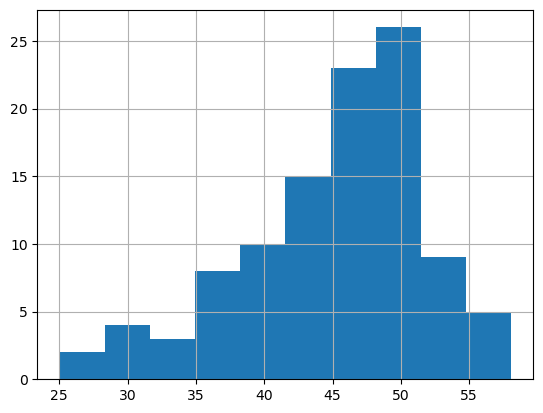

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Controleer op NaN of oneindige waarden en verwijder deze uit de kolom T5
t5_cleaned = data_clean['T5'].replace([np.inf, -np.inf], np.nan).dropna()
t5_cleaned.hist()


### Simple Train / Test Split
- Hier pak ik 4 modellen, LR, Lasso, XGboost en Nul model en ik train deze modellen op de test en kijk naar de nauwkeurigheid op de test set. Dit is nog zonder parameter optimalisatie. Alle modellen. Inclusief de lasso regressie lijken het slechter te doen dan de null model.
- Daarna heb ik een RFE benadering geprobeerd met een lineare regressie model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import pandas as pd

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5'])
y = data_clean['T5']

# Remove rows with NaN or infinite values in X or y
mask = X.notna().all(axis=1) & np.isfinite(X).all(axis=1) & y.notna() & np.isfinite(y)
X = X[mask]
y = y[mask]

# Perform a simple train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Number of patients in the test set: {len(y_test)}')

# Initialize models
linear_reg = LinearRegression()
lasso_reg = Lasso(alpha=10, max_iter=10000)
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Train models
linear_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred_linear = linear_reg.predict(X_train)
y_test_pred_linear = linear_reg.predict(X_test)

y_train_pred_lasso = lasso_reg.predict(X_train)
y_test_pred_lasso = lasso_reg.predict(X_test)

y_train_pred_xgb = xgb_reg.predict(X_train)
y_test_pred_xgb = xgb_reg.predict(X_test)

# Null model (predict the mean of the train set)
y_train_pred_null = np.full_like(y_train, y_train.mean(), dtype=np.float64)
y_test_pred_null = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Calculate metrics for each model on train and test sets
metrics = {
    'Model': [],
    'Dataset': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}

for model_name, y_train_pred, y_test_pred in [
    ('Linear Regression', y_train_pred_linear, y_test_pred_linear),
    ('Lasso Regression', y_train_pred_lasso, y_test_pred_lasso),
    ('XGBoost Regression', y_train_pred_xgb, y_test_pred_xgb),
    ('Null Model', y_train_pred_null, y_test_pred_null)
]:
    for dataset, y_true, y_pred in [
        ('Train', y_train, y_train_pred),
        ('Test', y_test, y_test_pred)
    ]:
        mae, rmse, r2 = calculate_metrics(y_true, y_pred)
        metrics['Model'].append(model_name)
        metrics['Dataset'].append(dataset)
        metrics['MAE'].append(mae)
        metrics['RMSE'].append(rmse)
        metrics['R2'].append(r2)

# Convert metrics to a DataFrame for easy viewing
metrics_df = pd.DataFrame(metrics)

print(metrics_df)


Number of patients in the test set: 32
                Model Dataset       MAE      RMSE        R2
0   Linear Regression   Train  2.477008  3.161081  0.789015
1   Linear Regression    Test  7.477628  9.362080 -1.247339
2    Lasso Regression   Train  4.153266  5.312445  0.404106
3    Lasso Regression    Test  5.518221  6.700104 -0.151031
4  XGBoost Regression   Train  0.000377  0.000529  1.000000
5  XGBoost Regression    Test  5.196332  7.329485 -0.377434
6          Null Model   Train  5.235296  6.881922  0.000000
7          Null Model    Test  5.166496  6.259338 -0.004571


In [6]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Assuming data_clean is already defined and clean

# Select the features and target variable
X = data_clean.drop(columns=['T5'])
y = data_clean['T5']

# Remove rows with NaN or infinite values in X or y
mask = X.notna().all(axis=1) & np.isfinite(X).all(axis=1) & y.notna() & np.isfinite(y)
X = X[mask]
y = y[mask]

# Perform a simple train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Recursive Feature Elimination based on p-values
def recursive_feature_elimination(X, y, threshold=0.05):
    X = X.copy()
    while True:
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        pvalues = model.pvalues[1:]  # exclude the intercept
        max_pvalue = pvalues.max()
        if max_pvalue > threshold:
            feature_to_remove = pvalues.idxmax()
            X = X.drop(columns=[feature_to_remove])
        else:
            break
    return X.columns[1:]  # exclude the constant

# Perform RFE on the training set
selected_features = recursive_feature_elimination(X_train, y_train)

# Train a linear regression model with selected features
linear_reg = LinearRegression()
linear_reg.fit(X_train[selected_features], y_train)

# Predict on train and test sets
y_train_pred = linear_reg.predict(X_train[selected_features])
y_test_pred = linear_reg.predict(X_test[selected_features])

# Define a function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Calculate metrics for train and test sets
train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred)

# Print results
print("Selected features:", selected_features)
print(f'Train MAE: {train_mae}')
print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')

# Add metrics to metrics_df
new_metrics = {
    'Model': ['Linear Regression - RFE', 'Linear Regression - RFE'],
    'Dataset': ['Train', 'Test'],
    'MAE': [train_mae, test_mae],
    'RMSE': [train_rmse, test_rmse],
    'R2': [train_r2, test_r2]
}

new_metrics_df = pd.DataFrame(new_metrics)

# Assuming metrics_df is already defined from previous models
metrics_df = pd.concat([metrics_df, new_metrics_df], ignore_index=True)
print(metrics_df)


Selected features: Index(['T0_Tumorsize', 'T0_CT_SMI', 'T0'], dtype='object')
Train MAE: 4.225875014844661
Train RMSE: 5.4113932560282345
Train R2: 0.3750992179513407
Test MAE: 4.928842469909662
Test RMSE: 6.320821417686787
Test R2: -0.11696796842261259
                     Model Dataset       MAE      RMSE        R2
0        Linear Regression   Train  2.477008  3.161081  0.789015
1        Linear Regression    Test  7.477628  9.362080 -1.247339
2         Lasso Regression   Train  4.153266  5.312445  0.404106
3         Lasso Regression    Test  5.518221  6.700104 -0.151031
4       XGBoost Regression   Train  0.000377  0.000529  1.000000
5       XGBoost Regression    Test  5.196332  7.329485 -0.377434
6               Null Model   Train  5.235296  6.881922  0.000000
7               Null Model    Test  5.166496  6.259338 -0.004571
8  Linear Regression - RFE   Train  4.225875  5.411393  0.375099
9  Linear Regression - RFE    Test  4.928842  6.320821 -0.116968


#### K-Fold Cross Validation - train/validation set
- Dataset wordt gesplitst in trainings- en testsets.
- Er wordt een 5-voudige cross-validatie uitgevoerd met hyperparameter tuning voor zowel Lasso Regression als XGBoost Regression om de beste modelconfiguratie te vinden.
- Het beste model wordt opnieuw getraind op de volledige trainingsset en geëvalueerd op de testset, waarbij de prestaties worden gemeten met MAE, RMSE en R².
- Een null model, dat het gemiddelde van de trainingsset voorspelt, wordt gebruikt als benchmark om de prestaties van de regressiemodellen te vergelijken.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

# Assuming data_clean is already cleaned and imputed

# Remove rows with missing values in T5
data_clean = data_clean.dropna(subset=['T5'])

# Remove rows where T5 > 80
data_clean = data_clean[data_clean['T5'] <= 80]

# Split data into features (X) and target (y)
X = data_clean.drop(columns=['T5'])
y = data_clean['T5']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Perform 5-fold cross-validation with hyperparameter tuning
def perform_cv_and_tuning(model, param_grid, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

# Lasso Regression
lasso = Lasso(max_iter=10000)
lasso_param_grid = {'alpha': np.logspace(-4, 5, 50)}
best_lasso = perform_cv_and_tuning(lasso, lasso_param_grid, X_train, y_train)

# XGBoost Regression
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
best_xgb = perform_cv_and_tuning(xgb_reg, xgb_param_grid, X_train, y_train)

# Null Model
class NullModel:
    def fit(self, X, y):
        self.mean = y.mean()
    def predict(self, X):
        return np.full(len(X), self.mean)

null_model = NullModel()
null_model.fit(X_train, y_train)

# Evaluate models
metrics = {
    'Model': [],
    'Dataset': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}

# Lasso Regression
y_train_pred_lasso = best_lasso.predict(X_train)
y_test_pred_lasso = best_lasso.predict(X_test)
train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred_lasso)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred_lasso)
metrics['Model'].extend(['Lasso Regression', 'Lasso Regression'])
metrics['Dataset'].extend(['Train', 'Test'])
metrics['MAE'].extend([train_mae, test_mae])
metrics['RMSE'].extend([train_rmse, test_rmse])
metrics['R2'].extend([train_r2, test_r2])

# XGBoost Regression
y_train_pred_xgb = best_xgb.predict(X_train)
y_test_pred_xgb = best_xgb.predict(X_test)
train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred_xgb)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred_xgb)
metrics['Model'].extend(['XGBoost Regression', 'XGBoost Regression'])
metrics['Dataset'].extend(['Train', 'Test'])
metrics['MAE'].extend([train_mae, test_mae])
metrics['RMSE'].extend([train_rmse, test_rmse])
metrics['R2'].extend([train_r2, test_r2])

# Null Model
y_train_pred_null = null_model.predict(X_train)
y_test_pred_null = null_model.predict(X_test)
train_mae, train_rmse, train_r2 = calculate_metrics(y_train, y_train_pred_null)
test_mae, test_rmse, test_r2 = calculate_metrics(y_test, y_test_pred_null)
metrics['Model'].extend(['Null Model', 'Null Model'])
metrics['Dataset'].extend(['Train', 'Test'])
metrics['MAE'].extend([train_mae, test_mae])
metrics['RMSE'].extend([train_rmse, test_rmse])
metrics['R2'].extend([train_r2, test_r2])

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the results
print(metrics_df)


                Model Dataset       MAE      RMSE        R2
0    Lasso Regression   Train  4.549965  5.604977  0.329590
1    Lasso Regression    Test  4.805724  6.171891 -0.064952
2  XGBoost Regression   Train  1.992920  2.617246  0.853822
3  XGBoost Regression    Test  4.188396  5.816543  0.054147
4          Null Model   Train  5.386419  6.845475  0.000000
5          Null Model    Test  4.871789  6.088768 -0.036460


In [ ]:
# Get the intercept and coefficients from the best Lasso model
lasso_intercept = best_lasso.intercept_
lasso_coefficients = best_lasso.coef_

# Get the feature names
feature_names = X.columns

# Create the regression formula
regression_formula = f"y = {lasso_intercept:.4f}"
for coef, name in zip(lasso_coefficients, feature_names):
    if coef != 0:  # Include only non-zero coefficients
        regression_formula += f" + ({coef:.4f} * {name})"

print("Lasso Regression Formula:")
print(regression_formula)


In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the best XGBoost model
xgb_feature_importances = best_xgb.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.Explainer(best_xgb)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('Feature Importance with SHAP Values')
plt.show()

# SHAP summary plot with direction of association
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.title('SHAP Summary Plot')
plt.show()
